Note* A significant portion of this code was copied from the guide in: https://www.tensorflow.org/tutorials/generative/cvae

In [1]:
#Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import time
from music21 import stream,note

In [2]:
#Define the length of each sample
#Define the batch size
len_piece = 256
batch_size = 16

In [14]:
#Read processed songs from file and store in an array
songs_reshaped = pd.read_csv('C:/Users/Amir/Documents/Graduate School/SEP788_789/Project/music_dataset-main/all_songs_no_time.csv',delimiter=',',header=None).to_numpy(dtype='float32')

#Reshape songs so that each sample has a length of 256 (16 beats)
songs = songs_reshaped.reshape(-1,len_piece,128,1).astype('float32')

#Remove notes that occur <100 times to reduce sample size
songs = songs[:,:,30:90]
songs.shape

(1422, 256, 60, 1)

In [15]:
#Delete any sample that may contain only zeros after resizing
zero_images = np.empty(0).astype('int')
for i in range(songs.shape[0]):
    if np.all(songs[i]==0):
        zero_images = np.append(zero_images,i)
songs_nz = np.delete(songs,zero_images,axis=0)

In [16]:
#Split the dataset into train and test. Keep random state=1 for repeatable results
x_train,x_test = train_test_split(songs_nz, test_size = 0.25, random_state = 1)


In [17]:
#Replaces -1 with 0.5. For use with Relu activation functions.
x_train_norm = np.where(x_train==-1,0.5,x_train)
x_test_norm = np.where(x_test==-1,0.5,x_test)

In [18]:
#Store data into TF datasets
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train_norm)
                 .shuffle(x_train.shape[0]).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test_norm)
                .shuffle(x_test.shape[0]).batch(batch_size))

In [19]:
#Create CVAE Model Class
class CVAE(Model):
    def __init__(self, latent_dim):
        super(CVAE,self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16,3, input_shape = (len_piece,60,1),padding = 'same',activation='relu'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim),
        ]  
        )
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape = (latent_dim,)),
            layers.Dense(len_piece*60*16,activation='relu'),
            layers.Reshape(target_shape = (len_piece,60,16)),
            layers.Conv2DTranspose(16, 3, padding = 'same',activation='relu'),
            layers.Conv2DTranspose(1, 3,padding='same'),
        ])
    
    #Faster execution through TF Graph function instead of Python
    @tf.function

    #Given a sample of the latent distrubtion generates a sample
    def sample(self,eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100,self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    #Encode input into latent space
    #Output is split (1 for mean, the other for stdv)
    def encode(self,x):
        mean,logvar = tf.split(self.encoder(x), num_or_size_splits = 2, axis = 1)
        return mean, logvar
    
    #Apply reparameterization trick to allow back propogation to flow through random node
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape = mean.shape)
        return eps* tf.exp(logvar *.5)+mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [20]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.*np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean,logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

#Run as tf.function for more efficient training
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [45]:
#Generates images during training
def generate_and_save_images(model, epoch, z):
  #mean, logvar = model.encode(test_sample)
  #z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
    plt.subplot(2, 2, i + 1)
    plt.imshow(predictions[i, :, :,0], cmap='gray')
    plt.axis('off')

  plt.show()
  return predictions

In [21]:
# Set number of epochs to trian over
epochs = 100

# set the dimensionality of the latent space
latent_dim = 128

# set number of examples to generate
num_examples_to_generate = 4

# Setting seed for generating images
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

#Define model
model = CVAE(latent_dim)

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(2):
  test_sample = test_batch[0:num_examples_to_generate, :, :]

optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Train the model
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()

  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  predictions = generate_and_save_images(model, epoch, random_vector_for_generation)

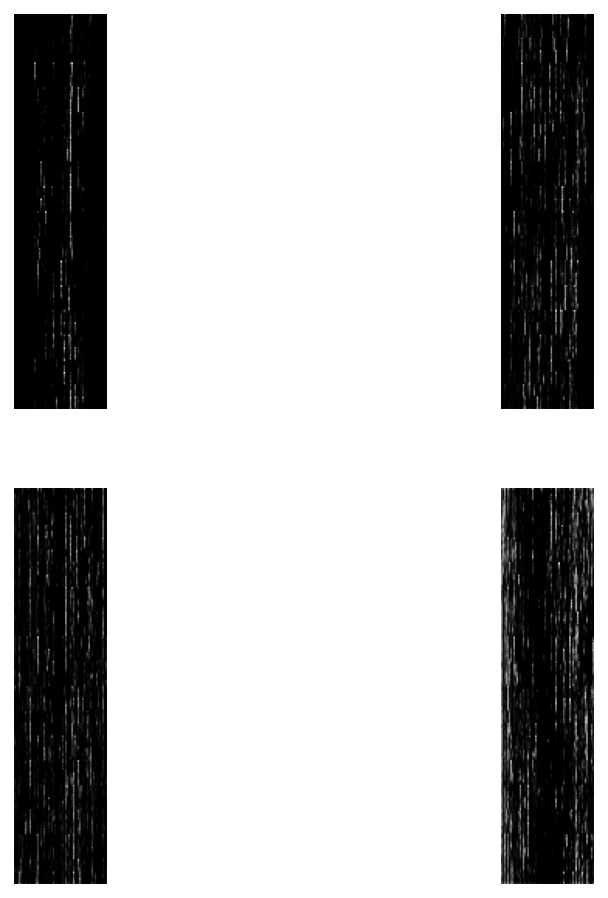

In [59]:
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
predictions = generate_and_save_images(model, 0, random_vector_for_generation)

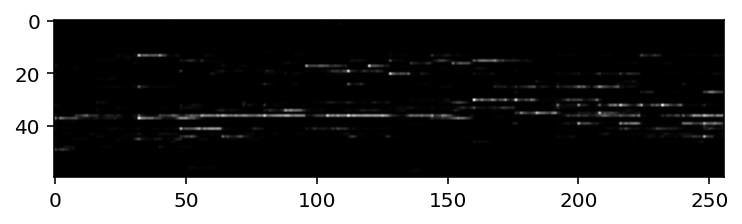

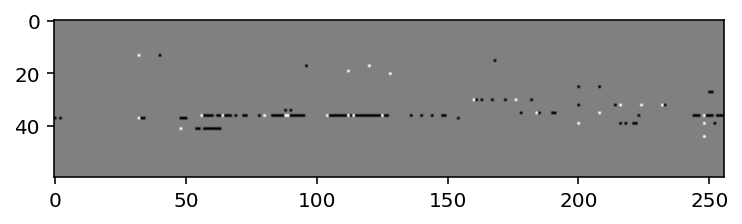

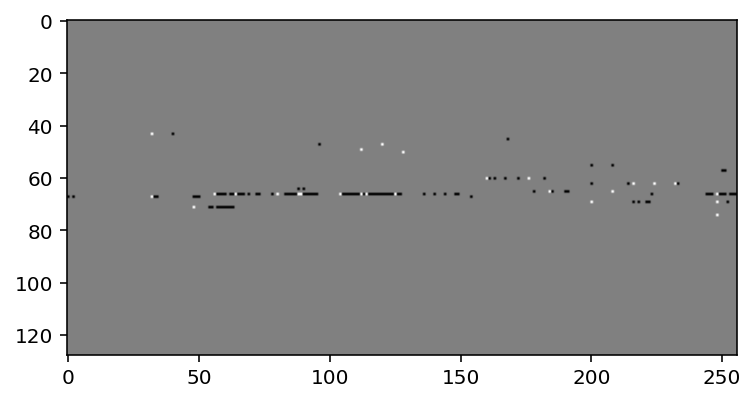

In [66]:
A = predictions[0].numpy().reshape(len_piece,60)
plt.imshow(A.transpose())
plt.show()
#Set threshold for which to decide whether a note is played or held
B = np.where(A>0.6,1,A)
B = np.where((B>0.4) & (B<0.6),-1,B)
B = np.where(abs(B)<0.4,0,B)
plt.imshow(B.transpose())
plt.show()

#Append notes we took away at the beginning as rows of 0s
C = np.append(np.zeros((len_piece,30)),B,axis=1)
C = np.append(C,np.zeros((len_piece,38)),axis=1)
plt.imshow(C.transpose())
plt.gray()
plt.show()

In [29]:
# Reconstruct a song from the multi-hot encoding
def reconMusic(song):
    recon_A = stream.Stream();
    #Insert back the timestamps
    A = np.insert(song,0,np.arange(0,int(len_piece/16),0.0625),axis=1)
    for row in range(A.shape[0]):
        for column in range(1,A.shape[1]):
            if(A[row,column]>0 and row+1<A.shape[0]):
                nt = note.Note()
                nt.pitch.midi = column-1
                ln_strt = 0
                i=1
                val = A[row+1,column]
                while(val <0 and row+i<A.shape[0]):
                    ln_strt=ln_strt+0.0625
                    val = A[row+i,column]
                    i=i+1
                if(row+i == A.shape[0]):
                    ln_strt= ln_strt+0.0625
                nt.quarterLength = ln_strt
                recon_A.append(nt)
                nt.offset = A[row,0]-A[0,0]
    return(recon_A)


In [67]:
reconMusic(C).show('midi')

In [ ]:
fp = reconMusic(b).write('midi', fp='C:/Users/Amir/Documents/Graduate School/SEP788_789/Project/music_dataset-main/generated_songs/sample5.mid')

In [ ]:
#Fixing arrays where there is a continuing note from a previous part
wr3 = np.where(songs_fixed[:,0,:]==-1)
for i in wr3:
    songs_fixed[i,0] = np.where(songs_fixed[i,0]==-1,1,songs_fixed[i,0])    